**reference--https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/**

**https://github.com/peterroelants/peterroelants.github.io/blob/main/notebooks/neural_net_implementation/neural-network-implementation-part03.ipynb**


**https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/**
- To manage memory run this code in terminal - -- jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000
- Import libraries

In [1]:
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp

# Load a CSV file
- Let's extract data from csv
- Change strings to float
- Chnage strings columns to integers
- Normalize dataset

In [2]:
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset
def str_column_to_float(datset, column):
    for row in dataset:
        row[column] = float(row[column].strip())
        
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

def dataset_minmax(dataset):
    minmax = list()
    stats = [[min(column), max(column)] for column in zip(*dataset)]
    return stats

def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)-1):
            if(minmax[i][1]-minmax[i][0] !=0):
                row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
            else: row[i] = row[i]=0;

# Test training backprop algorithm in seed data

- Use of cross validation
- Split train and test set
- Split a dataset into k folds**


In [3]:
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calculate accuracy percentage

In [4]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


**Evaluate an algorithm using a cross validation split**

**input	 dataset)train patterns**

**input	 (algorithm)function to init and train the network + perform predictions**

**input	 (n_folds)dataset spliter number**

**input	 (*args) = (l_rate, n_epoch, n_hidden)**

In [5]:
# def evaluate_algorithm(dataset, algorithm, n_folds, *args):
#     folds = cross_validation_split(dataset, n_folds)
#     scores = list()
#     for fold in folds:
#         train_set = list(folds)
#         train_set.remove(fold)
#         train_set = sum(train_set, [])
#         test_set = list()
#         for row in fold:
#             row_copy = list(row)
#             test_set.append(row_copy)
#             row_copy[-1] = None
#         predicted = algorithm(train_set, test_set, *args)
#         actual = [row[-1] for row in fold]
#         accuracy = accuracy_metric(actual, predicted)
#         scores.append(accuracy)
#     return scores


pred = []
act = []
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
        pred.append(predicted)
        act.append(accuracy)
    return scores

In [6]:
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation


In [7]:
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))


In [8]:
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs


# def forward_propagate(network, row):
#     inputs = row
#     #hidden layer
#     layer = network[0]
#     new_inputs = []
#     for neuron in layer:
#         activation = activate(neuron['weights'], inputs)
#         neuron['output'] = transfer(activation)
#         new_inputs.append(neuron['output'])
#         inputs = new_inputs
#         #output layer
#         layer = network[1]
#         new_inputs = []
#         for neuron in layer:
#             activation = activate(neuron['weights'], inputs)
#             neuron['output'] = softmax(activation)
#             new_inputs.append(neuron['output'])
#         inputs = new_inputs
#     return inputs

In [9]:
def transfer_derivative(output):
    return output * (1.0 - output)

# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

In [10]:
# Update network weights with error
def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += l_rate * neuron['delta']


In [11]:
# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
    #accuracy = []
    for epoch in range(n_epoch):
        sum_error = 0
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1
            sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))


# Initialize a network

Below is a function named initialize_network() that creates a new neural network ready for training. It accepts three parameters, the number of inputs, the number of neurons to have in the hidden layer and the number of outputs.


We can see that for the hidden layer we create n_hidden neurons and each neuron in the hidden layer has n_inputs + 1 weights, one for each input column in a dataset and an additional one for the bias.

We can also see that the output layer that connects to the hidden layer has n_outputs neurons, each with n_hidden + 1 weights. This means that each neuron in the output layer connects to (has a weight for) each neuron in the hidden layer.

- Create dictionary to store WEIGHTS as: [{'weights': [x x x] }, {...}, {'weights': [x x x]}]

In [12]:
# Initialize a network
# def initialize_network(n_inputs, n_hidden, n_outputs):
#     network = list()
#     hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
#     network.append(hidden_layer)
#     output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
#     network.append(output_layer)
#     return network
def initialize_network(n_inputs, hidden_list, n_outputs):
    network = list()
    hidden_layer = [{'weights': [random() for i in range(n_inputs + 1)]} for i in range(hidden_list[0])]
    network.append(hidden_layer)
    for h in range(len(hidden_list) - 1):
        # print("h:",h)
        hidden_layer = [{'weights': [random() for i in range(hidden_list[h] + 1)]} for i in range(hidden_list[h + 1])]
        network.append(hidden_layer)

    output_layer = [{'weights': [random() for i in range(hidden_list[-1] + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    for layer in network:
        print("\nlayer no:", network.index(layer))
        for neuron in layer:
            print("neuron no:", layer.index(neuron))
            print(neuron)
    return network


In [13]:
# Make a prediction with a network
def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))

In [14]:
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    network = initialize_network(n_inputs, n_hidden, n_outputs)
    train_network(network, train, l_rate, n_epoch, n_outputs)
    predictions = list()
    for row in test:
        prediction = predict(network, row)
        predictions.append(prediction)
    return(predictions)

In [15]:
seed(1)

# load and prepare data
#filename = './data/only_position.csv'
filename = './data/11.csv'
dataset = load_csv(filename)[1:]

In [16]:
#dataset

In [17]:
for i in range(len(dataset[1])-1):
    str_column_to_float(dataset, i)
str_column_to_int(dataset, len(dataset[0])-1) # this column contain the grain type
# normalize input variables
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)

In [18]:
#minmax

In [19]:
len(dataset[0])-1

30

# evaluate algorithm

In [20]:
n_folds =10  # devide the data set in 10 sub set that are going to be used as training one by one
l_rate = 0.5 # number of iteration for the training
#n_hidden = 10
hidden_list = [10]
n_epoch = 200

scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, hidden_list)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))



layer no: 0
neuron no: 0
{'weights': [0.6749025775182691, 0.8033855134341553, 0.6598238917510797, 0.4262993787138545, 0.7374512500957098, 0.12568332230972723, 0.21213169303189394, 0.04744017352451846, 0.07072687788690923, 0.07644615553590373, 0.9171763132459553, 0.29787980574251793, 0.15820738983282634, 0.5649407226767994, 0.13039112842440792, 0.5607173210286936, 0.850526660963271, 0.5905839712874152, 0.21759033920020698, 0.9008129952123803, 0.460852490153291, 0.8279131566567798, 0.8698864279223623, 0.7800172694327171, 0.6229628138905298, 0.03742337508476401, 0.20040745546617267, 0.0990253627729546, 0.5733827030223086, 0.8965657460164287, 0.5914093121448057]}
neuron no: 1
{'weights': [0.4923507504494802, 0.9379539017823154, 0.3900605387693097, 0.5041073672458524, 0.01720019672323503, 0.6121283611030989, 0.40232471301911965, 0.2813517154611124, 0.15696529448667917, 0.8575367430429213, 0.8111390619505175, 0.5633405356310336, 0.1351431409947249, 0.429240414597316, 0.2665354510728647, 0.0

>epoch=31, lrate=0.500, error=48.890
>epoch=32, lrate=0.500, error=42.817
>epoch=33, lrate=0.500, error=40.275
>epoch=34, lrate=0.500, error=37.659
>epoch=35, lrate=0.500, error=36.244
>epoch=36, lrate=0.500, error=29.495
>epoch=37, lrate=0.500, error=25.315
>epoch=38, lrate=0.500, error=22.656
>epoch=39, lrate=0.500, error=20.501
>epoch=40, lrate=0.500, error=20.342
>epoch=41, lrate=0.500, error=18.204
>epoch=42, lrate=0.500, error=15.977
>epoch=43, lrate=0.500, error=15.581
>epoch=44, lrate=0.500, error=16.052
>epoch=45, lrate=0.500, error=15.013
>epoch=46, lrate=0.500, error=14.327
>epoch=47, lrate=0.500, error=12.885
>epoch=48, lrate=0.500, error=11.064
>epoch=49, lrate=0.500, error=10.576
>epoch=50, lrate=0.500, error=15.671
>epoch=51, lrate=0.500, error=15.225
>epoch=52, lrate=0.500, error=10.546
>epoch=53, lrate=0.500, error=14.009
>epoch=54, lrate=0.500, error=9.876
>epoch=55, lrate=0.500, error=9.530
>epoch=56, lrate=0.500, error=9.314
>epoch=57, lrate=0.500, error=9.136
>epoc

>epoch=6, lrate=0.500, error=118.194
>epoch=7, lrate=0.500, error=118.172
>epoch=8, lrate=0.500, error=118.145
>epoch=9, lrate=0.500, error=118.111
>epoch=10, lrate=0.500, error=118.067
>epoch=11, lrate=0.500, error=118.009
>epoch=12, lrate=0.500, error=117.924
>epoch=13, lrate=0.500, error=117.793
>epoch=14, lrate=0.500, error=117.563
>epoch=15, lrate=0.500, error=117.076
>epoch=16, lrate=0.500, error=115.863
>epoch=17, lrate=0.500, error=114.031
>epoch=18, lrate=0.500, error=111.890
>epoch=19, lrate=0.500, error=104.022
>epoch=20, lrate=0.500, error=85.322
>epoch=21, lrate=0.500, error=68.022
>epoch=22, lrate=0.500, error=53.722
>epoch=23, lrate=0.500, error=44.255
>epoch=24, lrate=0.500, error=38.752
>epoch=25, lrate=0.500, error=35.617
>epoch=26, lrate=0.500, error=32.794
>epoch=27, lrate=0.500, error=29.080
>epoch=28, lrate=0.500, error=25.634
>epoch=29, lrate=0.500, error=23.617
>epoch=30, lrate=0.500, error=21.430
>epoch=31, lrate=0.500, error=18.182
>epoch=32, lrate=0.500, erro

>epoch=5, lrate=0.500, error=120.377
>epoch=6, lrate=0.500, error=120.372
>epoch=7, lrate=0.500, error=120.368
>epoch=8, lrate=0.500, error=120.363
>epoch=9, lrate=0.500, error=120.359
>epoch=10, lrate=0.500, error=120.354
>epoch=11, lrate=0.500, error=120.349
>epoch=12, lrate=0.500, error=120.345
>epoch=13, lrate=0.500, error=120.340
>epoch=14, lrate=0.500, error=120.335
>epoch=15, lrate=0.500, error=120.329
>epoch=16, lrate=0.500, error=120.324
>epoch=17, lrate=0.500, error=120.318
>epoch=18, lrate=0.500, error=120.312
>epoch=19, lrate=0.500, error=120.305
>epoch=20, lrate=0.500, error=120.298
>epoch=21, lrate=0.500, error=120.290
>epoch=22, lrate=0.500, error=120.282
>epoch=23, lrate=0.500, error=120.272
>epoch=24, lrate=0.500, error=120.262
>epoch=25, lrate=0.500, error=120.251
>epoch=26, lrate=0.500, error=120.238
>epoch=27, lrate=0.500, error=120.223
>epoch=28, lrate=0.500, error=120.205
>epoch=29, lrate=0.500, error=120.185
>epoch=30, lrate=0.500, error=120.160
>epoch=31, lrate=

>epoch=0, lrate=0.500, error=171.235
>epoch=1, lrate=0.500, error=118.807
>epoch=2, lrate=0.500, error=118.446
>epoch=3, lrate=0.500, error=118.437
>epoch=4, lrate=0.500, error=118.428
>epoch=5, lrate=0.500, error=118.418
>epoch=6, lrate=0.500, error=118.407
>epoch=7, lrate=0.500, error=118.395
>epoch=8, lrate=0.500, error=118.381
>epoch=9, lrate=0.500, error=118.366
>epoch=10, lrate=0.500, error=118.348
>epoch=11, lrate=0.500, error=118.327
>epoch=12, lrate=0.500, error=118.301
>epoch=13, lrate=0.500, error=118.268
>epoch=14, lrate=0.500, error=118.224
>epoch=15, lrate=0.500, error=118.165
>epoch=16, lrate=0.500, error=118.078
>epoch=17, lrate=0.500, error=117.941
>epoch=18, lrate=0.500, error=117.703
>epoch=19, lrate=0.500, error=117.222
>epoch=20, lrate=0.500, error=116.119
>epoch=21, lrate=0.500, error=114.276
>epoch=22, lrate=0.500, error=113.115
>epoch=23, lrate=0.500, error=112.063
>epoch=24, lrate=0.500, error=110.659
>epoch=25, lrate=0.500, error=108.318
>epoch=26, lrate=0.500

>epoch=9, lrate=0.500, error=116.748
>epoch=10, lrate=0.500, error=116.741
>epoch=11, lrate=0.500, error=116.734
>epoch=12, lrate=0.500, error=116.726
>epoch=13, lrate=0.500, error=116.717
>epoch=14, lrate=0.500, error=116.707
>epoch=15, lrate=0.500, error=116.696
>epoch=16, lrate=0.500, error=116.682
>epoch=17, lrate=0.500, error=116.666
>epoch=18, lrate=0.500, error=116.646
>epoch=19, lrate=0.500, error=116.621
>epoch=20, lrate=0.500, error=116.587
>epoch=21, lrate=0.500, error=116.539
>epoch=22, lrate=0.500, error=116.466
>epoch=23, lrate=0.500, error=116.343
>epoch=24, lrate=0.500, error=116.101
>epoch=25, lrate=0.500, error=115.529
>epoch=26, lrate=0.500, error=114.305
>epoch=27, lrate=0.500, error=113.385
>epoch=28, lrate=0.500, error=112.757
>epoch=29, lrate=0.500, error=111.934
>epoch=30, lrate=0.500, error=110.955
>epoch=31, lrate=0.500, error=109.787
>epoch=32, lrate=0.500, error=108.315
>epoch=33, lrate=0.500, error=106.148
>epoch=34, lrate=0.500, error=99.635
>epoch=35, lra

>epoch=17, lrate=0.500, error=112.800
>epoch=18, lrate=0.500, error=110.960
>epoch=19, lrate=0.500, error=106.301
>epoch=20, lrate=0.500, error=86.916
>epoch=21, lrate=0.500, error=69.568
>epoch=22, lrate=0.500, error=55.876
>epoch=23, lrate=0.500, error=46.577
>epoch=24, lrate=0.500, error=39.671
>epoch=25, lrate=0.500, error=36.623
>epoch=26, lrate=0.500, error=33.074
>epoch=27, lrate=0.500, error=27.804
>epoch=28, lrate=0.500, error=24.712
>epoch=29, lrate=0.500, error=21.722
>epoch=30, lrate=0.500, error=19.876
>epoch=31, lrate=0.500, error=19.312
>epoch=32, lrate=0.500, error=18.308
>epoch=33, lrate=0.500, error=17.202
>epoch=34, lrate=0.500, error=16.498
>epoch=35, lrate=0.500, error=15.856
>epoch=36, lrate=0.500, error=15.978
>epoch=37, lrate=0.500, error=14.013
>epoch=38, lrate=0.500, error=13.536
>epoch=39, lrate=0.500, error=12.245
>epoch=40, lrate=0.500, error=15.266
>epoch=41, lrate=0.500, error=12.462
>epoch=42, lrate=0.500, error=12.745
>epoch=43, lrate=0.500, error=14.22

>epoch=2, lrate=0.500, error=117.221
>epoch=3, lrate=0.500, error=117.206
>epoch=4, lrate=0.500, error=117.188
>epoch=5, lrate=0.500, error=117.168
>epoch=6, lrate=0.500, error=117.144
>epoch=7, lrate=0.500, error=117.112
>epoch=8, lrate=0.500, error=117.070
>epoch=9, lrate=0.500, error=117.010
>epoch=10, lrate=0.500, error=116.914
>epoch=11, lrate=0.500, error=116.740
>epoch=12, lrate=0.500, error=116.359
>epoch=13, lrate=0.500, error=115.432
>epoch=14, lrate=0.500, error=114.267
>epoch=15, lrate=0.500, error=113.587
>epoch=16, lrate=0.500, error=112.786
>epoch=17, lrate=0.500, error=111.870
>epoch=18, lrate=0.500, error=110.874
>epoch=19, lrate=0.500, error=109.795
>epoch=20, lrate=0.500, error=108.598
>epoch=21, lrate=0.500, error=107.183
>epoch=22, lrate=0.500, error=105.243
>epoch=23, lrate=0.500, error=100.537
>epoch=24, lrate=0.500, error=69.266
>epoch=25, lrate=0.500, error=55.156
>epoch=26, lrate=0.500, error=46.462
>epoch=27, lrate=0.500, error=40.265
>epoch=28, lrate=0.500, 

>epoch=13, lrate=0.500, error=114.925
>epoch=14, lrate=0.500, error=114.905
>epoch=15, lrate=0.500, error=114.880
>epoch=16, lrate=0.500, error=114.849
>epoch=17, lrate=0.500, error=114.809
>epoch=18, lrate=0.500, error=114.756
>epoch=19, lrate=0.500, error=114.683
>epoch=20, lrate=0.500, error=114.573
>epoch=21, lrate=0.500, error=114.396
>epoch=22, lrate=0.500, error=114.074
>epoch=23, lrate=0.500, error=113.440
>epoch=24, lrate=0.500, error=112.457
>epoch=25, lrate=0.500, error=111.486
>epoch=26, lrate=0.500, error=110.461
>epoch=27, lrate=0.500, error=109.654
>epoch=28, lrate=0.500, error=108.814
>epoch=29, lrate=0.500, error=107.788
>epoch=30, lrate=0.500, error=106.359
>epoch=31, lrate=0.500, error=98.505
>epoch=32, lrate=0.500, error=75.156
>epoch=33, lrate=0.500, error=62.161
>epoch=34, lrate=0.500, error=53.164
>epoch=35, lrate=0.500, error=46.905
>epoch=36, lrate=0.500, error=41.887
>epoch=37, lrate=0.500, error=38.266
>epoch=38, lrate=0.500, error=35.114
>epoch=39, lrate=0.5

>epoch=2, lrate=0.500, error=153.643
>epoch=3, lrate=0.500, error=118.145
>epoch=4, lrate=0.500, error=118.139
>epoch=5, lrate=0.500, error=118.135
>epoch=6, lrate=0.500, error=118.130
>epoch=7, lrate=0.500, error=118.124
>epoch=8, lrate=0.500, error=118.119
>epoch=9, lrate=0.500, error=118.113
>epoch=10, lrate=0.500, error=118.107
>epoch=11, lrate=0.500, error=118.100
>epoch=12, lrate=0.500, error=118.093
>epoch=13, lrate=0.500, error=118.084
>epoch=14, lrate=0.500, error=118.075
>epoch=15, lrate=0.500, error=118.065
>epoch=16, lrate=0.500, error=118.052
>epoch=17, lrate=0.500, error=118.037
>epoch=18, lrate=0.500, error=118.020
>epoch=19, lrate=0.500, error=117.997
>epoch=20, lrate=0.500, error=117.967
>epoch=21, lrate=0.500, error=117.927
>epoch=22, lrate=0.500, error=117.867
>epoch=23, lrate=0.500, error=117.771
>epoch=24, lrate=0.500, error=117.595
>epoch=25, lrate=0.500, error=117.212
>epoch=26, lrate=0.500, error=116.306
>epoch=27, lrate=0.500, error=115.175
>epoch=28, lrate=0.5

>epoch=15, lrate=0.500, error=117.246
>epoch=16, lrate=0.500, error=117.230
>epoch=17, lrate=0.500, error=117.211
>epoch=18, lrate=0.500, error=117.187
>epoch=19, lrate=0.500, error=117.156
>epoch=20, lrate=0.500, error=117.112
>epoch=21, lrate=0.500, error=117.048
>epoch=22, lrate=0.500, error=116.945
>epoch=23, lrate=0.500, error=116.765
>epoch=24, lrate=0.500, error=116.415
>epoch=25, lrate=0.500, error=115.788
>epoch=26, lrate=0.500, error=115.093
>epoch=27, lrate=0.500, error=114.434
>epoch=28, lrate=0.500, error=113.593
>epoch=29, lrate=0.500, error=112.430
>epoch=30, lrate=0.500, error=110.438
>epoch=31, lrate=0.500, error=97.457
>epoch=32, lrate=0.500, error=79.155
>epoch=33, lrate=0.500, error=66.215
>epoch=34, lrate=0.500, error=56.206
>epoch=35, lrate=0.500, error=48.967
>epoch=36, lrate=0.500, error=44.399
>epoch=37, lrate=0.500, error=40.017
>epoch=38, lrate=0.500, error=32.951
>epoch=39, lrate=0.500, error=28.564
>epoch=40, lrate=0.500, error=26.141
>epoch=41, lrate=0.500

[95.45454545454545, 95.45454545454545, 100.0, 100.0, 100.0, 90.9090909090909, 90.9090909090909, 100.0, 86.36363636363636, 90.9090909090909]


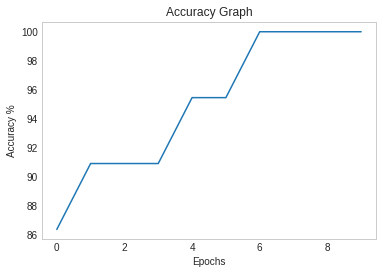

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd
import os

print(act)
#print(scores.sort())
lst1  = act.sort()
plt.plot(act)
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy Graph")
plt.grid(False)
plt.show()
#plt.savefig('./accuracy.png')

In [22]:
n_inputs = len(dataset[0]) - 1
n_outputs = len(set([row[-1] for row in dataset]))
network = initialize_network(n_inputs, [2], n_outputs)
train_network(network, dataset, 0.09, 20, n_outputs)
#for layer in network:
    #print(layer)

for row in dataset:
    prediction = predict(network, row)
    #print('Expected=%d, Got=%d' % (row[-1], prediction))
    result = ['Expected=%d, Got=%d' % (row[-1], prediction)]
    #result.to_csv(os.path.join(dir,"test_result.csv"), index=False)
    print(result)


layer no: 0
neuron no: 0
{'weights': [0.7517354444660674, 0.34741857849040236, 0.808404444776557, 0.8514997251217465, 0.03903581489434549, 0.11082315672373677, 0.6923246116877775, 0.7513484079256405, 0.2294148543323833, 0.5834620552955234, 0.5670219083427072, 0.01039446149638168, 0.8058358069624261, 0.9776782451654604, 0.47495488605354286, 0.7639251643696476, 0.9388055961515326, 0.9990476140864705, 0.9777569538896111, 0.8839445438242085, 0.07757588442042984, 0.5979577301727033, 0.9286155093135209, 0.2474836450585549, 0.6440978711177824, 0.5502334472115689, 0.992112093662832, 0.4010136584851871, 0.6111978418733967, 0.7319158312689003, 0.3301810115152203]}
neuron no: 1
{'weights': [0.12948689711728667, 0.6079856074258372, 0.68840901462859, 0.11647065078615304, 0.7753112393127993, 0.5959400033819607, 0.9995448013619677, 0.3524466828064333, 0.8987506117325774, 0.7005449968215023, 0.00866812515079507, 0.7982907552733485, 0.9420754068829608, 0.4328183361446921, 0.3976110913560903, 0.6846154

In [23]:

#from datetime import datetime
import numpy as np
import pandas as pd
import csv
import os
import datetime
import time

from datetime import datetime
extension = ".csv"
date = datetime.now().strftime("%Y_%m_%d")
filename = date + extension
dir = "../result"
#x = datetime.date.today()
#date = datetime.now().strftime("%Y_%m_%d")
if not os.path.exists(dir):
    os.mkdir(dir)

viscous = 0.02  
radius = 0.01
A_YM = 300 *(10**6)
B_YM = 5 *(10**6)
ratio = round(A_YM/B_YM,3)
percentage = round(((A_YM-B_YM)/A_YM)*100,3)

    
accuracy = sum(scores)/float(len(scores))
result = [radius, date,viscous,  n_folds, n_epoch, l_rate, A_YM, B_YM, ratio,percentage, round(accuracy,3)]
with open(os.path.join(dir,filename),'a',newline ="") as f:
    writer = csv.writer(f)
    writer.writerow(["radius(%)","date", "viscous", "n_folds", "n_epoch", "l_rate","A_YM","B_YM","ratio","percentage","Accuracy%"])
    writer.writerow(result)
    
#open('myfile.%d.dat' % time.time(), 'w+')